# Libraries Used

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize 
import copy
from matplotlib.ticker import PercentFormatter
import seaborn as sb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/apple/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Portfolio Object

$\textcolor{red}{\text{Base to be built on. Doesn't need to be modified to run code.}}$

In [2]:
class Portfolio:
    """
    A class for managing a portfolio of securities, including functionalities for downloading historical data,
    calculating returns, volatility, and the Sharpe ratio, and optimizing the portfolio based on various criteria.

    Attributes:
        risk_free_rate (float): The risk-free rate obtained from "^IRX" ticker for 1 month period, used in Sharpe ratio calculation.
        period (str): The time period for which to fetch historical data.
        interval (str): The frequency at which to sample historical data.
        tickers (list[str]): A list of ticker symbols in the portfolio.
        weights (np.ndarray): The allocation weights for each security in the portfolio.
        data (pd.DataFrame): Historical data for all tickers in the portfolio.
        prices (pd.DataFrame): Adjusted close prices for all tickers.
        returns (pd.DataFrame): Daily percentage returns for all tickers.
        covariance (pd.DataFrame): Covariance matrix of the returns.
        expected_return (pd.Series): Mean daily return for each ticker.
        portfolio_return (float): Expected return of the portfolio.
        portfolio_historical_return (pd.Series): Historical returns of the portfolio.
        portfolio_volatility (float): Volatility (standard deviation) of the portfolio returns.
        portfolio_sharpe_ratio (float): Sharpe ratio of the portfolio.

    Methods:
        __copy__(): Returns a deep copy of the portfolio instance.
        __repr__(): String representation of the portfolio instance.
        add_tickers(tickers): Adds new securities to the portfolio and updates metrics.
        set_weights(weights): Sets the investment weights for the securities in the portfolio.
        set_expected_return(expected_return): Sets the expected returns for the securities in the portfolio.
        negative_sharpe_ratio(weights): Calculates the negative Sharpe ratio for optimization.
        maximize_sharpe(bounds, constraints): Optimizes the portfolio to maximize the Sharpe ratio.
        minimize_variance(bounds, constraints): Optimizes the portfolio to minimize variance.
    """

    def __init__(self,tickers,period,interval) -> None:
        """
        Initializes the Portfolio object with tickers, period, and interval. Downloads historical data and calculates initial portfolio metrics.

        Parameters:
            tickers (list[str]): List of stock ticker symbols.
            period (str): Time period for which to fetch historical data.
            interval (str): Frequency at which to sample historical data.
        """
        self.risk_free_rate = yf.download("^IRX", period="1mo", interval="1mo")['Close'][-1]/100
        self.period = period
        self.interval = interval
        self.market = yf.download("^GSPC", period=self.period, interval=self.interval)['Adj Close']
        self.market_returns = self.market.pct_change().dropna()
        dummy = tickers.copy()
        self.tickers = sorted(dummy)
        self.weights = np.ones(len(self.tickers))/len(self.tickers)
        self.data = yf.download(self.tickers, period=self.period, interval=self.interval).dropna()
        self.prices = self.data['Adj Close']
        self.returns = self.data['Adj Close'].pct_change().dropna()
        self.covariance = self.returns.cov(ddof=1)
        self.expected_return = self.returns.mean()
        self.volatilities = self.returns.std()
        self.portfolio_return = self.weights @ self.expected_return
        self.portfolio_historical_return = (self.weights * self.returns).sum(axis=1)
        self.portfolio_volatility = np.sqrt(self.weights.T @ self.covariance @ self.weights)
        self.portfolio_sharpe_ratio = (self.portfolio_return - self.risk_free_rate)/self.portfolio_volatility

    def __copy__(self):
        """Returns a deep copy of the portfolio instance."""
        return copy.deepcopy(self)
    
    def __repr__(self) -> str:
        """String representation of the Portfolio object."""
        return f"Portfolio(tickers={self.tickers}, period={self.period}, interval={self.interval})"

    def add_tickers(self, tickers) -> None:
        """
        Adds new ticker symbols to the portfolio, updates historical data, and recalculates portfolio metrics.

        Parameters:
            tickers (list[str]): List of new ticker symbols to add to the portfolio.
        """
        for ticker in tickers:
            self.tickers.append(ticker)
            data = yf.download(ticker, period=self.period, interval=self.interval).dropna()
            for i in data.columns.get_level_values(0).unique():
                self.data[i,ticker] = data[i]
            self.prices = self.prices.assign(**{ticker: self.data['Adj Close'][ticker]})
            self.returns[ticker] = self.prices[ticker].pct_change().dropna()
        self.covariance = self.returns.cov().dropna()
        dummy = self.tickers.copy()
        self.tickers = sorted(dummy)
        self.weights = np.ones(len(self.tickers))/len(self.tickers)
        self.expected_return = self.returns.mean()
        self.volatilities = self.returns.std()
        self.portfolio_return = self.weights.T @ self.expected_return
        self.portfolio_volatility = np.sqrt(self.weights.T @ self.covariance @ self.weights)
        self.portfolio_sharpe_ratio = (self.portfolio_return - self.risk_free_rate)/self.portfolio_volatility
        
    def correlation_heatmap(self):
        """
        Shows the correlation heatmap for the securities' returns in the portfolio.

        Parameters:
            
        """
        returns_corr = self.returns.corr()
        mask = np.triu(np.ones_like(returns_corr, dtype=bool), 1)
        plt.figure(figsize=(12,8))
        plt.title('Correlation Heatmap')
        sb.heatmap(returns_corr, annot=True, cmap='coolwarm', mask=mask)
        plt.show()

    def historicals(self):
        """
        Shows a scatter plot of the securities' returns & std in the portfolio.

        Parameters:
            
        """
        fig, axes = plt.subplots(1,2, figsize=(12,8))
        axes[0].set_title('Historical returns & volatilities')
        axes[0].scatter(self.volatilities, self.expected_return, c=self.volatilities)
        for tick_name, ret, vol in zip(self.expected_return.index, self.volatilities, self.expected_return):
            axes[0].annotate(tick_name, (ret, vol), c='black', xytext=(-10,10), textcoords='offset points')

        axes[0].set_xlabel('Volatility')
        axes[0].set_ylabel('Expected Return')
        axes[0].grid(True, ls='--')

        axes[1].set_title('Rolling volatilities')
        self.returns.rolling(int(len(self.returns)/8)).std().dropna().plot(ax=axes[1])
        axes[1].legend()
        fig.legend()
        fig.show()

    def set_weights(self, weights) -> None:
        """
        Sets the allocation weights for the securities in the portfolio.

        Parameters:
            weights (np.ndarray): An array of weights corresponding to each security in the portfolio.
        """
        self.weights = weights
        self.portfolio_return = self.weights @ self.expected_return
        self.portfolio_historical_return = (self.weights * self.returns).sum(axis=1)
        self.portfolio_volatility = np.sqrt(self.weights.T @ self.covariance @ self.weights)
        self.portfolio_sharpe_ratio = (self.portfolio_return - self.risk_free_rate)/self.portfolio_volatility

    
    def set_expected_return(self, expected_return) -> None:
        """
        Sets the expected returns for the securities in the portfolio.

        Parameters:
            expected_return (np.ndarray): An array of expected returns for each security in the portfolio.
        """
        self.expected_return = expected_return
        self.portfolio_return = self.weights @ self.expected_return
        self.portfolio_sharpe_ratio = (self.portfolio_return - self.risk_free_rate)/self.portfolio_volatility
    
    def CAPM_set_expected_return(self):
        """
        Sets the expected returns for the securities in the portfolio according to CAPM.
        """
        beta = np.array([np.polyfit(self.market_returns.reindex(self.returns.index), self.returns[tick], 1)[0] for tick in self.returns])
        CAPM = self.risk_free_rate + beta * (self.market_returns.mean() - self.risk_free_rate/12)
        self.set_expected_return(CAPM)

    def set_covariance(self, covariance) -> None:
        """
        Sets the covariance matrix for the securities in the portfolio.

        Parameters:
            covariance (pd.DataFrame): A covariance matrix for the securities in the portfolio.
        """
        self.covariance = covariance
        self.portfolio_volatility = np.sqrt(self.weights.T @ self.covariance @ self.weights)
        self.portfolio_sharpe_ratio = (self.portfolio_return - self.risk_free_rate)/self.portfolio_volatility

    def negative_sharpe_ratio(self, weights):
        """
        Calculates the negative Sharpe ratio of the portfolio for a given set of weights.

        Parameters:
            weights (np.ndarray): An array of weights for the portfolio's securities.

        Returns:
            float: The negative Sharpe ratio of the portfolio.
        """
        # Portfolio return
        port_return = np.dot(weights, self.expected_return)
        # Portfolio volatility
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(self.covariance, weights)))
        # Sharpe ratio
        return -(port_return -self.risk_free_rate) / port_volatility  # Negative for minimization

    def maximize_sharpe(self,bounds,constraints):
        """
        Optimizes the portfolio to maximize the Sharpe ratio under given constraints.

        Parameters:
            bounds (list of tuples): Constraints for each weight in the optimization problem.
            constraints (dict): General constraints for the optimization problem.
        """
        # Run the optimization
        result = minimize(self.negative_sharpe_ratio, x0=np.ones(len(self.tickers))/len(self.tickers), method='SLSQP', bounds=bounds, constraints=constraints)
        self.weights = result.x
        self.portfolio_return = self.weights.T @ self.expected_return
        self.portfolio_volatility = np.sqrt(self.weights.T @ self.covariance @ self.weights)
        self.portfolio_sharpe_ratio = (self.portfolio_return - self.risk_free_rate)/self.portfolio_volatility
        self.portfolio_historical_return = self.returns @ self.weights.T

    def minimize_variance(self,bounds, constraints):
        """
        Optimizes the portfolio to minimize its variance (volatility) under given constraints.

        Parameters:
            bounds (list of tuples): Constraints for each weight in the optimization problem.
            constraints (dict): General constraints for the optimization problem.
        """
        result =  minimize(lambda weights: weights.T @ self.covariance @weights, x0=np.ones(len(self.tickers))/len(self.tickers), bounds=bounds, method='SLSQP', constraints=constraints)
        self.weights = result.x
        self.portfolio_return = self.weights.T @ self.expected_return
        self.portfolio_volatility = np.sqrt(self.weights.T @ self.covariance @ self.weights)
        self.portfolio_sharpe_ratio = (self.portfolio_return - self.risk_free_rate)/self.portfolio_volatility
        self.portfolio_historical_return = self.returns @ self.weights.T
        
    def efficient_frontier_plot(self, num_points=10000, show=True):
        """
        Plots the efficient frontier for the portfolio.

        Parameters:
            num_points (int): Number of points to sample for the efficient frontier.
            show (bool): Whether to show the plot or not.
        """
        # Generate random weights
        random_weights = np.random.random((num_points, len(self.tickers)))
        random_weights /= np.sum(random_weights, axis=1)[:, np.newaxis]
        # Calculate portfolio return and volatility
        port_returns = np.dot(random_weights, self.expected_return)
        port_volatility = np.sqrt((random_weights @ self.covariance @ random_weights.T))
        port_volatility = np.diagonal(port_volatility)
        # Calculate Sharpe ratio
        sharpe_ratio = (port_returns - self.risk_free_rate)/port_volatility
        # Plot efficient frontier
        plt.figure(figsize=(12,8))
        plt.scatter(port_volatility, port_returns, c=sharpe_ratio, cmap='viridis')
        plt.plot(self.portfolio_volatility, self.portfolio_return, 'r*', markersize=15)
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1,2))
        plt.gca().xaxis.set_major_formatter(PercentFormatter(1,2))
        plt.title('Efficient Frontier')
        plt.show()




# Example

### Equally Weighted Portfolios

In [ ]:
tickers = ['AAPL','MSFT','TSLA','NVDA','AMD','TSM','BRK-B','GOOG']
period = '3y'
interval = '1mo'
portfolio = Portfolio(tickers,period, interval)
portfolio.add_tickers(['SMCI'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  1 of 1 completed


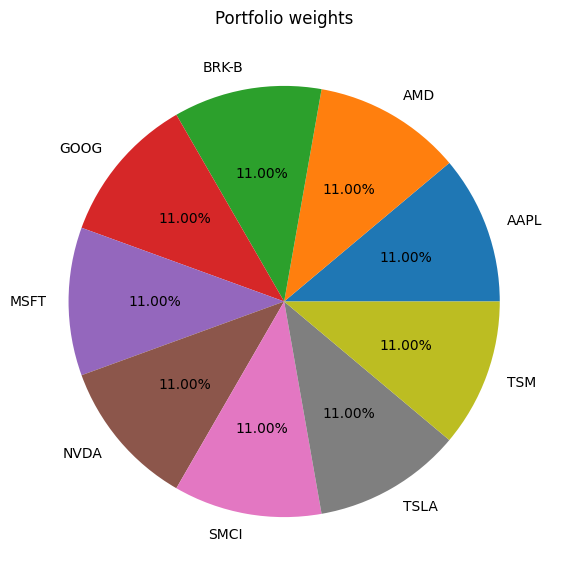

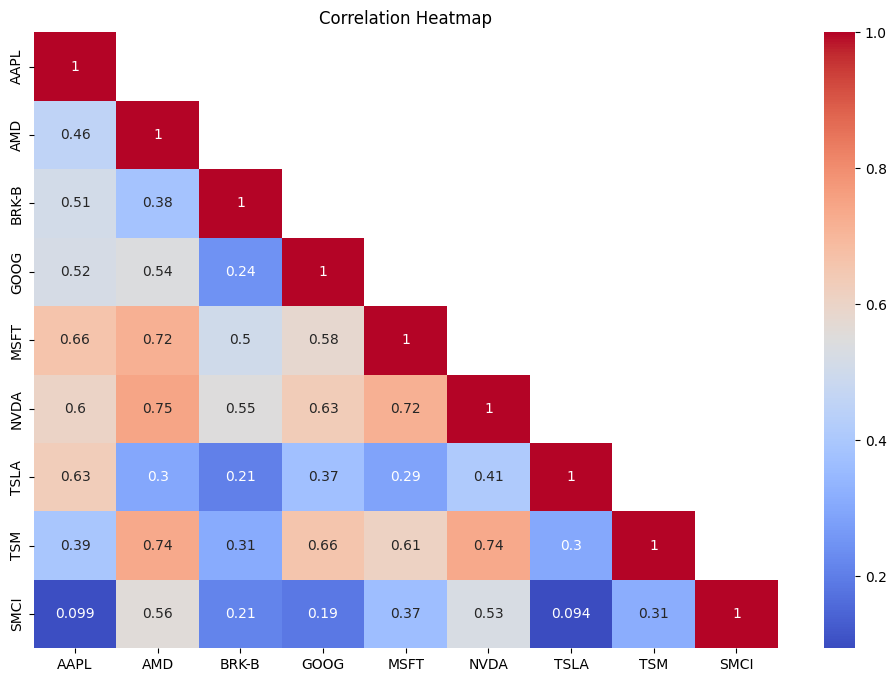

/var/folders/c_/g1xvtg0n703b521w01snnld80000gp/T/ipykernel_43113/3734917940.py:128: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


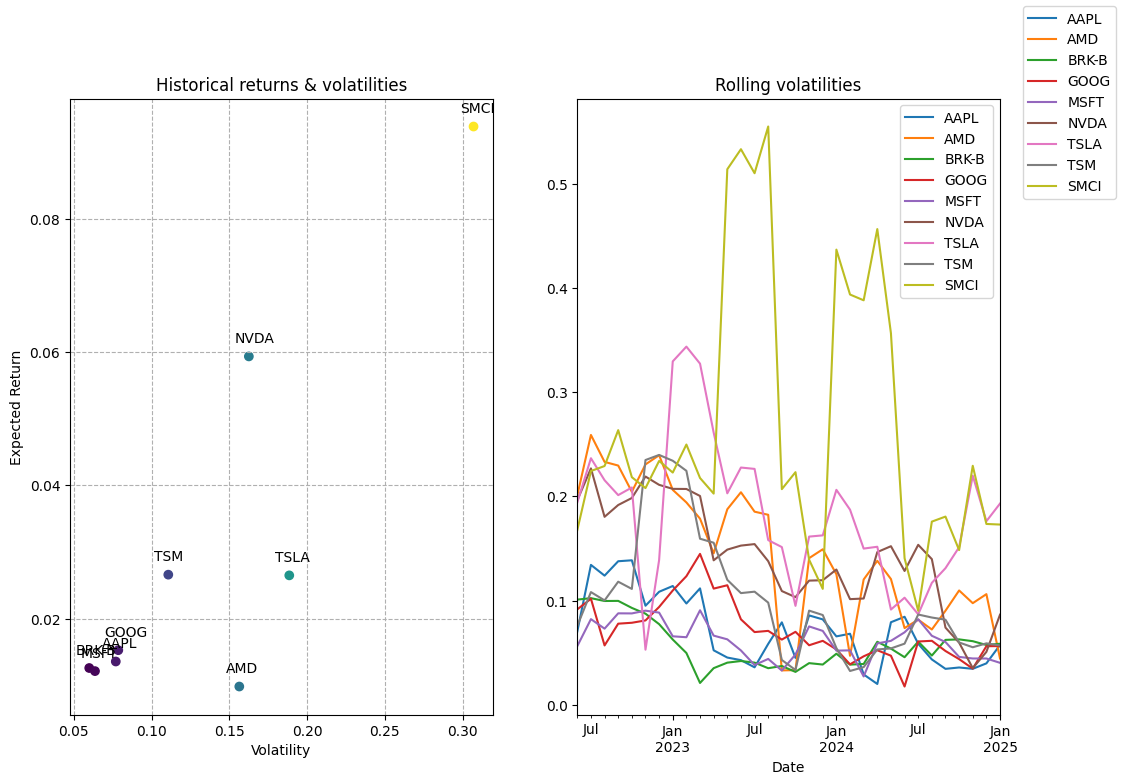

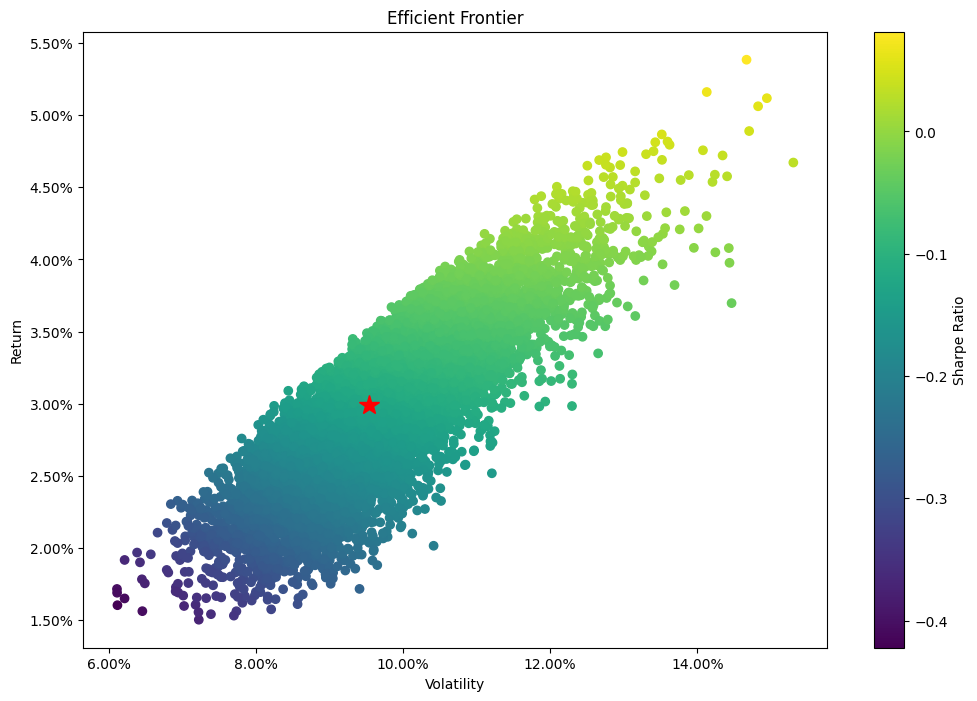

In [4]:
plt.figure(figsize=(10, 7))
plt.pie(portfolio.weights, labels=portfolio.tickers,autopct=lambda p: '{:.2f}%'.format(round(p)) if p > 0 else '')
plt.title('Portfolio weights')
plt.show()
portfolio.correlation_heatmap()
portfolio.historicals()
portfolio.efficient_frontier_plot()

### Optimized Portfolios

In [5]:
# BOUNDS
bounds = [(0,0.35)] * len(portfolio.tickers)
# CONSTRAINTS
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Weights sum to 1
    {'type': 'ineq', 'fun': lambda w: 0.10 - w[0]},   # Example: Limit AAPL to 10%
]
# OPTIMIZATION
portfolio_minimum_variance = portfolio.__copy__()
portfolio_minimum_variance.minimize_variance(bounds,constraints)
portfolio_maximum_sharpe = portfolio.__copy__()
portfolio_maximum_sharpe.maximize_sharpe(bounds,constraints)

### Plots

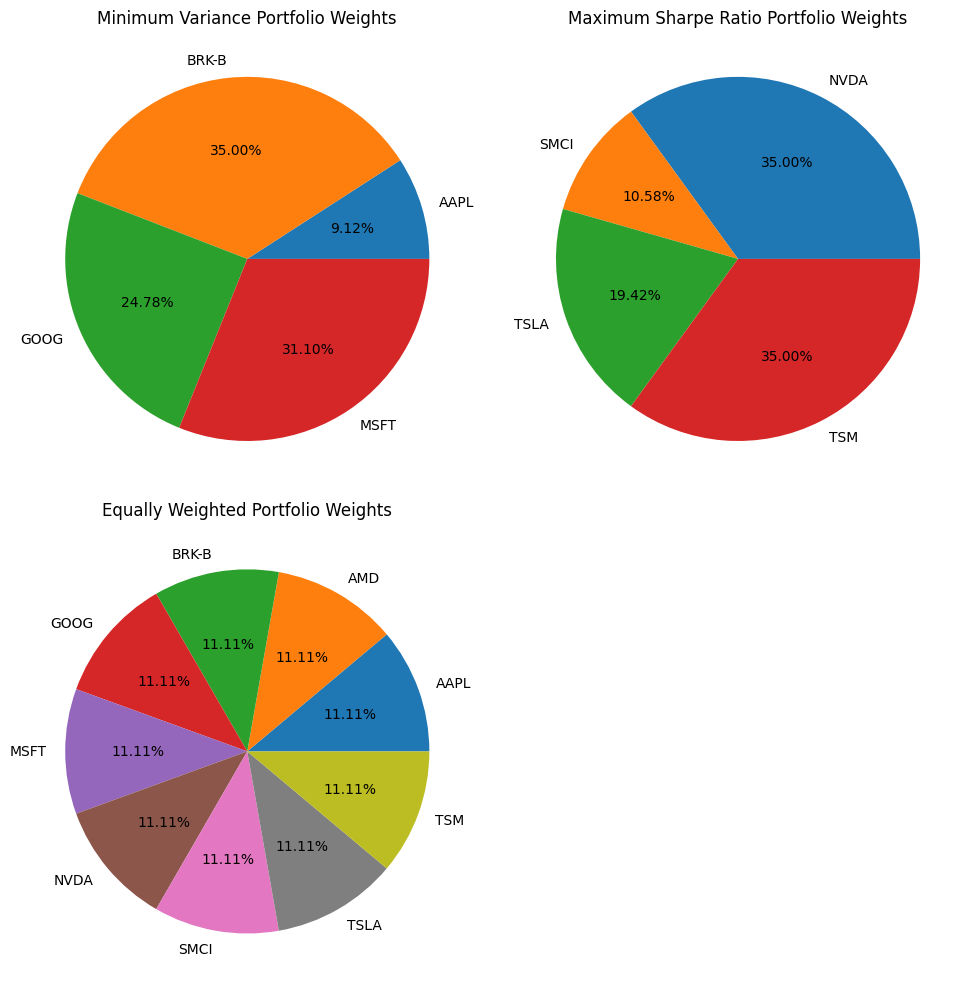

In [6]:
plt.figure(figsize=(10, 10))

# Set a threshold for filtering out small weights
threshold = 1e-4  # This can be adjusted to ensure very small weights are considered as 0%

# Minimum Variance Portfolio
plt.subplot(2, 2, 1)
# Filter out small weights and corresponding tickers for cleaner labels
min_variance_weights = [weight for weight in portfolio_minimum_variance.weights if weight > threshold]
min_variance_tickers = [ticker for weight, ticker in zip(portfolio_minimum_variance.weights, portfolio_minimum_variance.tickers) if weight > threshold]
plt.pie(min_variance_weights, labels=min_variance_tickers, autopct='%1.2f%%')
plt.title('Minimum Variance Portfolio Weights')

# Maximum Sharpe Ratio Portfolio
plt.subplot(2, 2, 2)
# Filter out small weights and corresponding tickers for cleaner labels
max_sharpe_weights = [weight for weight in portfolio_maximum_sharpe.weights if weight > threshold]
max_sharpe_tickers = [ticker for weight, ticker in zip(portfolio_maximum_sharpe.weights, portfolio_maximum_sharpe.tickers) if weight > threshold]
plt.pie(max_sharpe_weights, labels=max_sharpe_tickers, autopct='%1.2f%%')
plt.title('Maximum Sharpe Ratio Portfolio Weights')
# Equally Weighted Portfolio
plt.subplot(2,2,3)
plt.pie(portfolio.weights, labels=portfolio.tickers, autopct='%1.2f%%')
plt.title('Equally Weighted Portfolio Weights')

plt.tight_layout()
plt.show()


## Comparison With Market

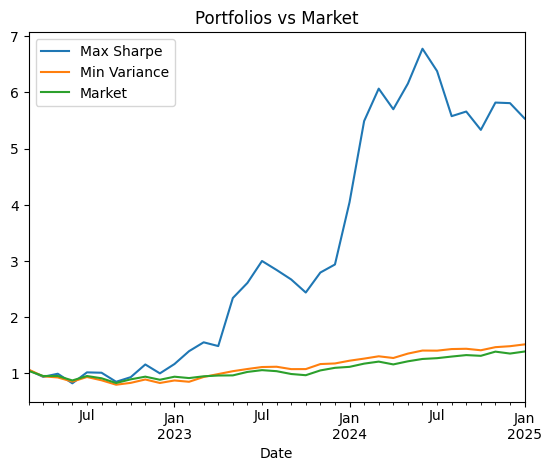

In [7]:
(1+portfolio_maximum_sharpe.portfolio_historical_return). cumprod().plot(label='Max Sharpe')
(1+portfolio_minimum_variance.portfolio_historical_return).cumprod().plot(label='Min Variance')
(1+portfolio_minimum_variance.market_returns).cumprod().plot(label='Market')
plt.title('Portfolios vs Market')
plt.legend()
plt.show()

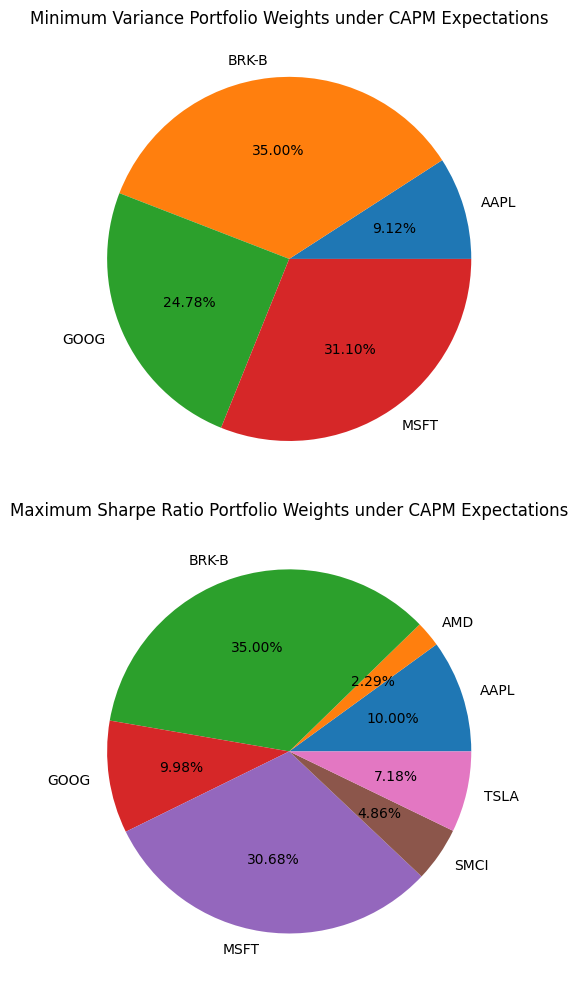

In [8]:
portfolio_capm = portfolio.__copy__()
portfolio_capm.CAPM_set_expected_return()
CAPM_max_sharpe = portfolio_capm.__copy__()
CAPM_max_sharpe.maximize_sharpe(bounds, constraints)
CAPM_min_variance = portfolio_capm.__copy__()
CAPM_min_variance.minimize_variance(bounds, constraints)

plt.figure(figsize=(10, 10))

# Set a threshold for filtering out small weights
threshold = 1e-4  # This can be adjusted to ensure very small weights are considered as 0%

# Minimum Variance Portfolio
plt.subplot(2, 1, 1)
# Filter out small weights and corresponding tickers for cleaner labels
min_variance_weights = [weight for weight in CAPM_min_variance.weights if weight > threshold]
min_variance_tickers = [ticker for weight, ticker in zip(CAPM_min_variance.weights, CAPM_min_variance.tickers) if weight > threshold]
plt.pie(min_variance_weights, labels=min_variance_tickers, autopct='%1.2f%%')
plt.title('Minimum Variance Portfolio Weights under CAPM Expectations')

# Maximum Sharpe Ratio Portfolio
plt.subplot(2, 1, 2)
# Filter out small weights and corresponding tickers for cleaner labels
max_sharpe_weights = [weight for weight in CAPM_max_sharpe.weights if weight > threshold]
max_sharpe_tickers = [ticker for weight, ticker in zip(CAPM_max_sharpe.weights, CAPM_max_sharpe.tickers) if weight > threshold]
plt.pie(max_sharpe_weights, labels=max_sharpe_tickers, autopct='%1.2f%%')
plt.title('Maximum Sharpe Ratio Portfolio Weights under CAPM Expectations')
# Equally Weighted Portfolio
plt.tight_layout()
plt.show()

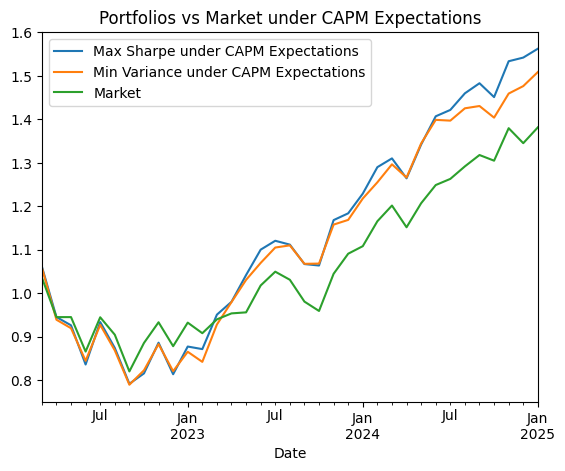

In [9]:
(1+CAPM_max_sharpe.portfolio_historical_return). cumprod().plot(label='Max Sharpe under CAPM Expectations')
(1+CAPM_min_variance.portfolio_historical_return).cumprod().plot(label='Min Variance under CAPM Expectations')
(1+portfolio_minimum_variance.market_returns).cumprod().plot(label='Market')
plt.title('Portfolios vs Market under CAPM Expectations')
plt.legend()
plt.show()